In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.optimize import fmin
from statsmodels.tsa.arima_model import ARMA

In [2]:
np.random.seed(1)

In [3]:
def ARMA(AR_param=[], MA_param=[], nsample=100, burnin=0, paths=1):
    AR_param = np.asarray(AR_param).reshape(-1, 1)
    rev_AR_param = AR_param[::-1]
    MA_param = np.asarray(MA_param).reshape(-1, 1)
    rev_MA_param = MA_param[::-1]
    p = len(AR_param)
    q = len(MA_param)
    max_order = max(p,q)
    
    ncol = max_order + burnin + nsample
    nrow = paths
    x_array = np.zeros((nrow, ncol))
    e_array = np.random.normal(loc=0.0, scale=1.0, size=(nrow, ncol))
    
    for i in range(max_order, ncol):
        x_array[:, i] = (x_array[:, i-p:i] @ rev_AR_param).flatten() + e_array[:, i]\
                        + (e_array[:, i-q:i] @ rev_MA_param).flatten()
        
    return x_array[:, max_order+burnin:].T

In [4]:
def simple_ols(y, X):
    y = np.asarray(y).reshape(-1,1)
    X = np.asarray(X).reshape(-1,1) if len(X.shape) == 1 else np.asarray(X)
    n = X.shape[0]
    beta = np.linalg.inv(X.T@X)@(X.T@y)
    y_fitted = X@beta
    e = np.reshape((y - y_fitted), (-1, 1))
    results = {"y": y,
               "X": X,
               "Fitted y": y_fitted,
               "Residuals": e,
               "Beta": beta}
    return results

In [5]:
def ACF(data, nlags):
    ACF_list = []
    for lag in range(nlags+1):
        data_lag = data.shift(periods=lag)
        mean = np.sum(data_lag[lag:])/(data_lag.shape[0]-lag)
        xt_demean = data - mean
        xt_lag_demean = data_lag - mean
        nom = np.sum(xt_demean*xt_lag_demean)
        denom = np.sum(xt_demean**2)
        ACF = nom/denom
        ACF_list.append(ACF)
    return np.asarray(ACF_list)

In [80]:
def avg_ACF(ols_list, nlags, navg):
    subset_ols = ols_list[:navg]
    sum_ACF = np.zeros(nlags+1)
    for ols in subset_ols:
        q1_AR1_residuals = pd.Series(ols["Residuals"].flatten())
        q1_AR1_ACF = ACF(q1_AR1_residuals, nlags=10)
        sum_ACF += q1_AR1_ACF
    avg_ACF = sum_ACF/len(subset_ols)
    return avg_ACF

In [6]:
def plot_ACF(ACF_result, nlags):
    x = np.arange(0, nlags+1)
    fig, ax = plt.subplots()
    ax.bar(x, ACF_result)
    ax.set_xlabel("Number of Lags")
    ax.set_ylabel("ACF")

In [123]:
def AR_p_OLS(ARMA_result, p):
    ols_result_list = []
    for i in range(ARMA_result.shape[1]):
        x = pd.Series(ARMA_result[:, i])
        df_X = x
        for j in range(1, p+1):
            x_lag_j = x.shift(periods=j)
            df_X = pd.concat([df_X, x_lag_j], axis=1)
        df_X = df_X.dropna()
        df_X_nolag = df_X.iloc[:,0]
        df_X_plags = df_X.iloc[:,1:p+1]
        ols_i_result = simple_ols(df_X_nolag, df_X_plags)
        ols_result_list.append(ols_i_result)
    return ols_result_list

In [83]:
def IV_AR1(ARMA_result):
    beta_hat_list = []
    for i in range(q1_ARMA11.shape[1]):
        xt = q1_ARMA11[:, i]
        X = xt[1:-1].reshape(-1,1)
        Z = xt[:-2].reshape(-1,1)
        Y = xt[2:].reshape(-1,1)
        beta_hat = np.linalg.inv(Z.T@X)@(Z.T@Y)
        beta_hat_list.append(beta_hat)
    return np.asarray(beta_hat_list)

## Q1.

### (a)

In [84]:
q1_AR_param = [0.8]
q1_MA_param = [0.7]
q1_ARMA11 = ARMA(q1_AR_param, q1_MA_param, 1000, 10, 10000)

In [85]:
q1_AR1_ols = AR_p_OLS(q1_ARMA11, 1)
q1_AR1_phihat = [ols["Beta"].item(0) for ols in q1_AR1_ols]
q1_AR1_phihat = np.asarray(q1_AR1_phihat)
q1_AR1_phihat_mean = np.mean(q1_AR1_phihat)

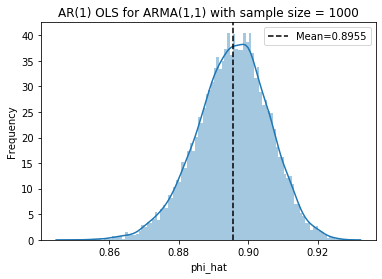

In [86]:
fig, ax = plt.subplots()
ax = sns.distplot(q1_AR1_phihat, bins=100)
plt.axvline(q1_AR1_phihat_mean, linestyle='--', color='k', label='Mean='+str(np.round(q1_AR1_phihat_mean, decimals=4)))
ax.set_xlabel("phi_hat")
ax.set_ylabel("Frequency")
ax.set_title("AR(1) OLS for ARMA(1,1) with sample size = 1000")
ax.legend()

### (b)

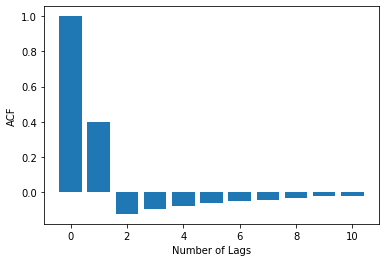

In [87]:
q1_AR1_ACF = avg_ACF(q1_AR1_ols, nlags=10, navg=100)
plot_ACF(q1_AR1_ACF, 10)

### (c)

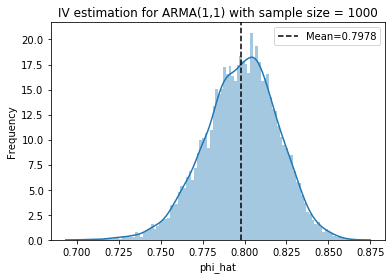

In [88]:
IV_phihat = IV_AR1(q1_ARMA11)
IV_phihat_mean = np.mean(IV_phihat)
fig, ax = plt.subplots()
ax = sns.distplot(IV_phihat, bins=100)
plt.axvline(IV_phihat_mean, linestyle='--', color='k', label='Mean='+str(np.round(IV_phihat_mean, decimals=4)))
ax.set_xlabel("phi_hat")
ax.set_ylabel("Frequency")
ax.set_title("IV estimation for ARMA(1,1) with sample size = 1000")
ax.legend()

In this case, IV is consistent.

## Q2.

### (a)(b)

In [158]:
lamda_list = [0.95, 0.9, 0.8]
phi1 = np.sum(lamda_list)
phi2 = -(0.95 * 0.9 + 0.9 * 0.8 + 0.95 * 0.8)
phi3 = 0.95*0.9*0.8
q2_AR_param = [phi1, phi2, phi3]
q2_MA_param = []
q2_ARMA30 = ARMA(q2_AR_param, q2_MA_param, 1000, 10, 10000)

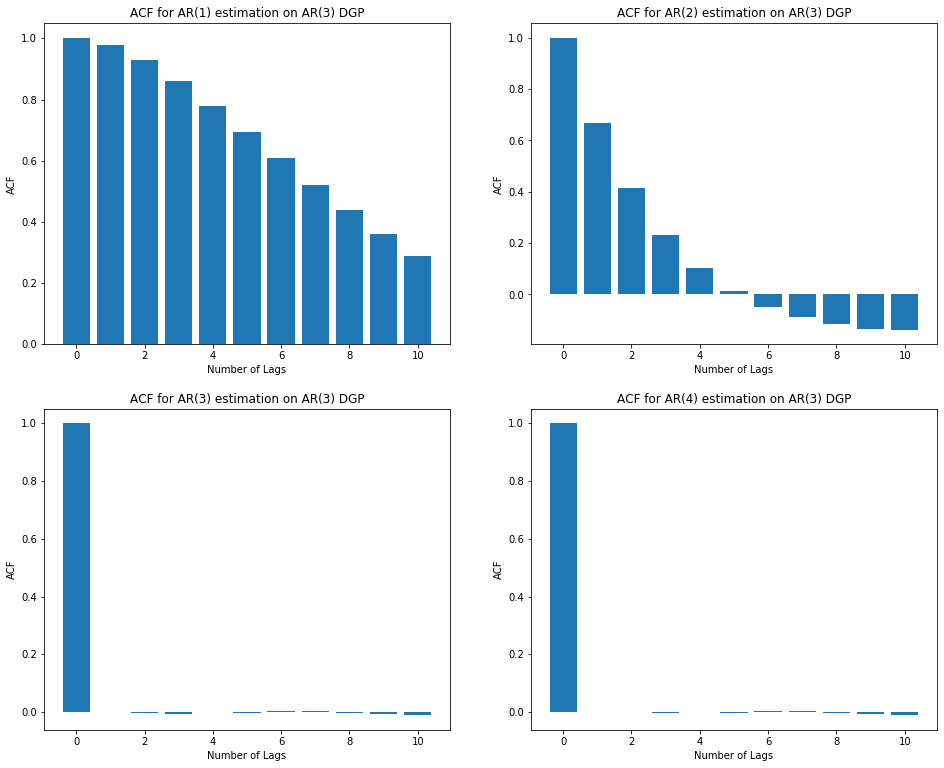

In [159]:
p_list = range(1,5)
fig, axes = plt.subplots(2,2,figsize=(16,13))
axes = axes.ravel()
for i, p in enumerate(p_list):
    q2_ARp_ols = AR_p_OLS(q2_ARMA30, p=p)
    q2_ARp_ACF = avg_ACF(q2_ARp_ols, nlags=10, navg=100)
    x = np.arange(0, 11)
    axes[i].bar(x, q2_ARp_ACF)
    axes[i].set_xlabel("Number of Lags")
    axes[i].set_ylabel("ACF")
    axes[i].set_title("ACF for AR({}) estimation on AR(3) DGP".format(p))

### (c)

For AR models, we can conclude that omitting lag variables is much severe than including extra lags.

## Q3

In [177]:
def Q3_process(mean, cov, nsample=1000, paths=100):
    X = np.random.multivariate_normal(mean, cov, (paths, nsample))
    X1 = X[:,:,0]
    X2 = X[:,:,1]
    E = np.random.normal(0,1,(paths, nsample))
    Y = X1 + X2 + E
    return Y.T, X1.T, X2.T

In [189]:
def Q3_phihat(Y, X1):
    q3_ols_result = []
    for i in range(Y.shape[1]):
        ols_i_result = simple_ols(Y[:, i], X1[:, i])
        q3_ols_result.append(ols_i_result)

    q3_phihat = [ols["Beta"].item(0) for ols in q3_ols_result]
    q3_phihat = np.asarray(q3_phihat)
    q3_phihat_mean = np.mean(q3_phihat)
    return q3_phihat, q3_phihat_mean

### (a)(b)(c)

In [198]:
q3_mean = [0, 0]
q3a_cov = [[1, 0], [0, 1]]
q3b_cov = [[1, 0.5], [0.5, 1]]
q3c_cov = [[1, -0.5], [-0.5, 1]]
q3_cov_list = [q3a_cov, q3b_cov, q3c_cov]

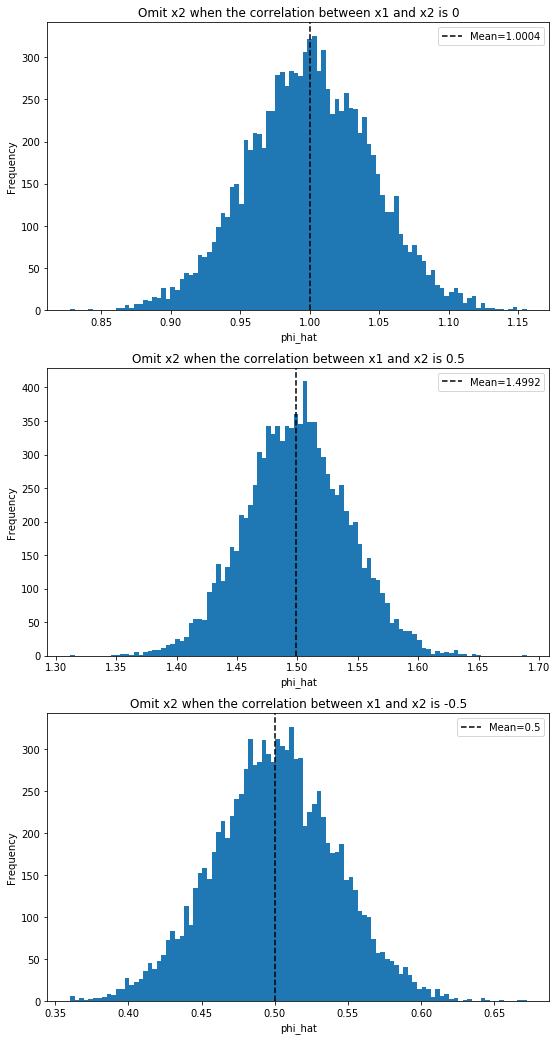

In [199]:
fig, axes = plt.subplots(3,1,figsize=(9,18))
axes = axes.ravel()
for i, cov in enumerate(q3_cov_list):
    Y, X1, X2 = Q3_process(mean=q3_mean, cov=cov, nsample=1000, paths=10000)
    q3_phihat, q3_phihat_mean = Q3_phihat(Y, X1)
    axes[i].hist(q3_phihat, bins=100)
    axes[i].axvline(q3_phihat_mean, linestyle='--', color='k', label='Mean='+str(np.round(q3_phihat_mean, decimals=4)))
    axes[i].set_xlabel("phi_hat")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title("Omit x2 when the correlation between x1 and x2 is {}".format(cov[0][1]))
    axes[i].legend()

### (d)

From the above results, we can see that when the covariance between x1 and x2 equaled to 0, the estimated beta for x1 when omitting x2 in the regression is still consistent. However, when x1 and x2 were correlated, the estimated beta is biased and inconsistent. We can conclude that, when regressors are orthogonal to errors, the estimation coefficients for the regressors are still consistent.

## Q4

In order to let the process be stationary, we need all roots outside unit circle.

The determinant of the characteristic matrix:

$\begin{vmatrix}
(1-0.5L) & -0.1L\\
(-0.4L-0.25L^2) & (1-0.5L)
\end{vmatrix}$

let det = $-0.025L^3+0.21L^2-L+1$ = 0

In [202]:
p = [-0.025, 0.21, -1, 1]
print(np.roots(p))

[3.55002152+4.2623464j 3.55002152-4.2623464j 1.29995695+0.j       ]


we can see that all roots are outside the unit circle, so the bivariate process is stationary

## Q5

### (b)

In [289]:
def Q5_MA1(mu, theta, sigma, e0):
    etm1 = e0
    zt_list = []
    et_list = []
    for i in range(100):
        et = np.random.normal(0, sigma**2, 1)
        zt = mu + et + 0.5 * etm1
        zt_list.append(zt)
        et_list.append(et)
        etm1 = et
    return np.asarray(zt_list)

In [290]:
q5_zt_list = Q5_MA1(1, 0.5, 1, 0)

In [291]:
def Q5_logL_MLE_MA1(param = []):
    mu, theta, sigma = param
    T = q5_zt_list.shape[0]
    e0 = 0
    eim1 = e0
    e_list = []
    for i in range(T):
        ei = q5_zt_list[i] - mu - theta * eim1
        eim1 = ei
        e_list.append(ei)
    e_list = np.asarray(e_list)
    logL = -T/2*np.log(2*np.pi)-T/2*np.log(sigma**2)-1/(2*sigma**2)*np.sum(e_list**2)
    return logL

In [292]:
def Q5_neg_logL(param = []):
    return -Q5_logL_MLE_MA1(param)

In [293]:
initial_guess = [0.5,0.5,0.5]
result = fmin(Q5_neg_logL, initial_guess)

Optimization terminated successfully.
         Current function value: 145.723670
         Iterations: 76
         Function evaluations: 139


In [296]:
print("[mu, theta, sigma]")
print(result)

[mu, theta, sigma]
[0.94189009 0.51457755 1.03902206]


### (C)

In [297]:
np.sqrt(np.diag(result.hess_inv)/100)

AttributeError: 'numpy.ndarray' object has no attribute 'hess_inv'

## (d)

In [285]:
model = ARMA(q5_zt_list, order=(0, 1))
model_fit = model.fit(method="css-mle", disp=False)

In [286]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(0, 1)   Log Likelihood                -149.279
Method:                       css-mle   S.D. of innovations              1.074
Date:                Thu, 16 Apr 2020   AIC                            304.557
Time:                        22:22:58   BIC                            312.373
Sample:                             0   HQIC                           307.720
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8928      0.171      5.226      0.000       0.558       1.228
ma.L1.y        0.5960      0.077      7.758      0.000       0.445       0.747
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.6778           +0.0000j            1.6778            0.5000
-----------------------------------------------------------------------------
"""